**In this project, we will work with data from one of Africa's largest open data platforms `openAfrica`. Air quality data would be analysed from Nairobi, Lagos, and Dar es Salaam; and a time-series model would be built to predict PM 2.5 readings throughout the day.**

Key Big-Picture Objectives of this project are:

* Getting data by querying a MongoDB database.
* Preparing time series data for analysis.
* Building an autoregression model.
* Improving a model by tuning its hyperparameters.

Time series models are a key part of Financial Engineering. Concepts learnt in this project will be helpful in Natural Language Processing as well

* MongoDB is a NoSQL or a semi-structured type database
* Commonly used in websites to store user-profiles, clicklogs etc.
* Also commonly used in Sensor Data

ML WORKFLOW: 
**PREPARING DATA**

1. **Connecting** to MongoDB server
    * Keywords: Client, server
2. **Exploring** the database and locate PM2.5 readings
    * What is the `data model` for a MongoDB database
    * What is semi-structured data
    * How to query a database using pymongo
    * Keywords: {Collection, document , primary key}, {metadata, schema}, {python object: iterator}
3. **Importing** database query into DataFrame

In [1]:
# Importing necessary libraries
from pprintpp import PrettyPrinter # For making printouts of objects like dictionaries from MongoDB easier to read
import pandas as pd
from pymongo import MongoClient # to get data from mongodb server

# 1. Connecting to MongoDB Server
* Results are obtained from MongoDB database in the form of Dictionaries.
* A large number of Keys and Values in the dictionary could be messy to read when printed.
* PrettyPrinter makes the imported dictionaries easier to read. 

**Instantiating a PrettyPrinter**

In [2]:
pp = PrettyPrinter(indent=2)

Creating a client that connects to database running at `localhost` on port `27017`
* `client = MongoClient(host = 'localhost', port = 27017)`

Database server is where the database resides; it can be accessed using a client. Port is the exact location. Think of client as a pipeline between our machine and database machine

1. *NOTE: THE FOLLOWING CODE WOULD NOT RUN BECAUSE WQU HAS DATA ON THEIR LOCAL SERVER IN THE VIRTUAL MACHINE*
2. **ITERATOR**: An iterator object goes over a task in a loop and gives out result
* `from sys import getsizeof`
* `my_list = [0,1,2,3,4,5,6,7,8]`
* `my_range = range(0,9) #iterator` Includes 0 but excludes 9

* `for i in my_range:`
*     `print(i)`
* `getsizeof(my_range)`
If the size in memory is comapared for my_list and my_range, it turns out that my_range occupies less space than my_list
* Python gets around this memory issue with an iterator. Iterator gets everything ready to give out as a stream of data one-by-one on demand. without storing in memory
* This is exactly how MongoDB database gives out query results by creating an iterator.

# 2. Exploring the database

Getting the names of databases on client
* `client.list_databases()`This returns an iterator from the server

* INPUT`pp.pprint(list(client.list_databases()))`This will generate a list of elements in iterator
* OUTPUT 
  `[ {'empty': False, 'name': 'admin', 'sizeOnDisk': 40960},
  {'empty': False, 'name': 'air-quality', 'sizeOnDisk': 6750208},
  {'empty': False, 'name': 'config', 'sizeOnDisk': 61440},
  {'empty': False, 'name': 'local', 'sizeOnDisk': 73728}]`
* It can be seen that there are three relatively small databases `admin`,`config` and `local`. These can be thought of as administrative databases which keep everything organised in a server
* What we are interested in is `air-quality` database. It can also be seen that it is the biggest in size, which is a good clue as to where data is

* Next step is to pull out `air-quality` database and assign it to a variable
* `db = client['air-quality']`
* **How MongoDB Databases are organised in general**
* SERVER
    * DATABASE
        * COLLECTION
            * DOCUMENT
* So far we have connected to the MongoDB server, found the database we are interested in (air-quality). Next step is to explore the collection and document inside this database
* Checking list of collections available in db variable
* INPUT `list(db.list_collections())[0]`
* OUTPUT `{'name': 'lagos',
 'type': 'timeseries',
 'options': {'timeseries': {'timeField': 'timestamp',
   'metaField': 'metadata',
   'granularity': 'seconds',
   'bucketMaxSpanSeconds': 3600}},
 'info': {'readOnly': False}}`


* As we can see the output is in form of a dictionary. JSON to be precise
* For now, we are only interested in the name of these collections
* INPUT `for c in db.list_collections():
    print(c['name'])`
* OUTPUT `lagos
system.buckets.lagos
dar-es-salaam
system.buckets.dar-es-salaam
nairobi
system.buckets.nairobi
system.views`

It can be seen that there are 3 collections in database: lagos, dar-es-salam and nairobi. the `system.buckets` thing is administrative stuff

In this project we are interested only in Nairobi collection. Assigning it to a variable nairobi
* INPUT `nairobi = db['nairobi']`

* Recall that it makes sense to check the shape and head of a dataframe when it is first loaded into memory from csv
* Similarly it is a good idea to count the number of documents in a database collection
* INPUT `nairobi.count_documents({})`
* OUTPUT `202212`
* **NOTE: collection arguments end with curly brackets inside parenthesis, which could mean that we are looking for dictionary entries?**

## Structured and Semi/Unstructured Data
* We are connected to the database. We have found nairobi collection and also know that there are over 200k documents in it. Next we need to check what those documents look like
* Before pulling documents out of the collection, it is necessary to understand how data is organised in a MongoDB
    * **structured data** or a SQL database)
    * **semi-structured/unstructured data** (noSQL database or MongoDB database)
* **Structured data has a very strict schema of organising data** 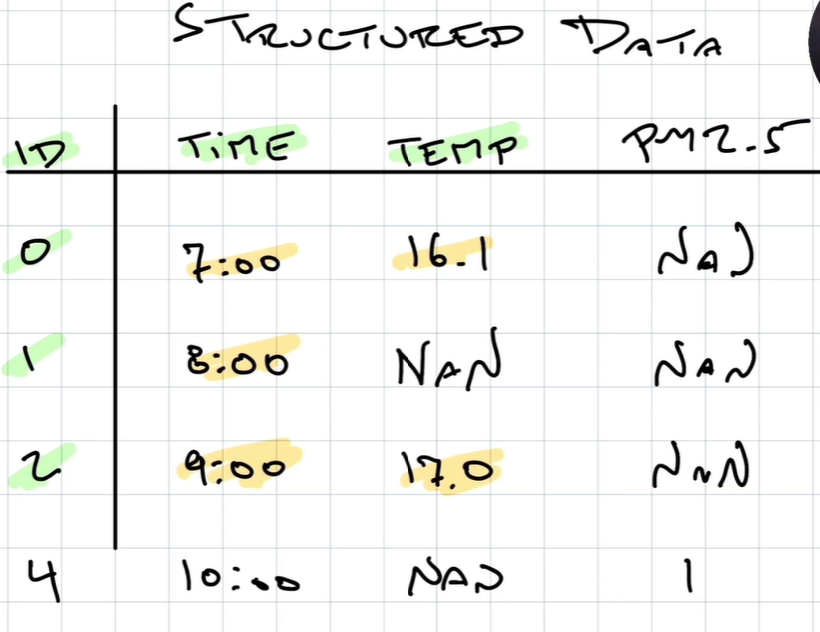
    * There can be no missing values. They must be filled with NaN. Every row and column must have value
    * The drawback is that everytime a new feature is created, a new column must be created as well. This increases the size of database
    * Structured data is very strict. Every observation needs to satisfy every attribute in the dataframe   

* **Semi-Structured data is a lot more flexible** 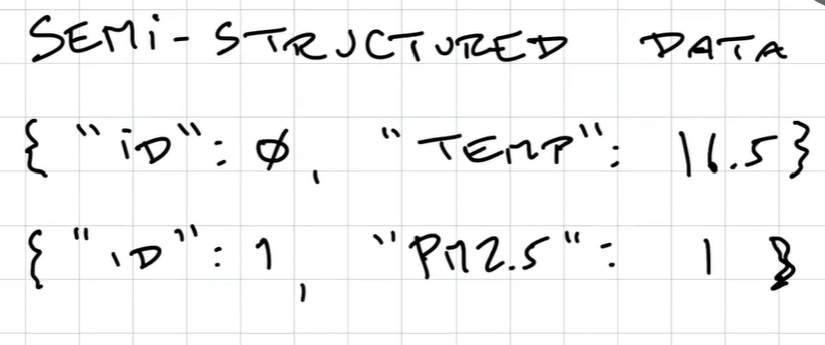
    * Readings can be organised as dictionaries. 
    * After a common key value pair (in this case `id`), it is possible to have any key value pair
    * There can be as many different keys as needed, and they can be named as required.
    * There is no restriction to enter a value for every feature in dataset

### Checking a record in nairobi collection
* INPUT 
* `result = nairobi.find_one({})`
* `pp.pprint(result)`
* OUTPUT 
* `{ 'P1': 39.67,`
* `'_id': ObjectId('6242117316585264f22eaf78'),`
* `'metadata': { 'lat': -1.3,`
* `                'lon': 36.785,`
* `                'measurement': 'P1',`
* `                'sensor_id': 57,`
* `                'sensor_type': 'SDS011',`
* `                'site': 29},`
* ` 'temperature': 16.5,`
* ` 'timestamp': datetime.datetime(2018, 9, 1, 0, 0, 2, 472000)}`

#### Observations
* We used `find_one` method to retrieve one document from nairobi collection and assigned it to variable `result`
* `'_id': ObjectId('6242117316585264f22eaf78'),` is called the **Primary Key**, which is a unique identifier for each record in a MongoDB database.
* `'temperature': 16.5,'timestamp': datetime.datetime(2018, 9, 1, 0, 0, 2, 472000)}` show the temperature and the time when it was recorded
* There also exits a `metadata` dictionary. Metadata means information about the data. This is the sensor data (id, model, location...)

### Aggregating data
* to figure out from where data can be pulled
* It would be curious to know how many distinct `sites` are there
* INPUT: 
* `nairobi.distinct('metadata.site')`
* OUTPUT:
* `[6, 29]`
* It turns out there are two sites in the dataset: Site 6 and Site 29.
* Next question would be to find which site has more data(documents) upon which a model can be built
* INPUT:
* `print("Documents from site 6:", nairobi.count_documents({'metadata.site':6}))
print("Documents from site 29:", nairobi.count_documents({'metadata.site':29}))`
* OUTPUT:
* `Documents from site 6: 70360
Documents from site 29: 131852`
* It turns out there is almost twice as much data at site 29 compared to site 6. It makes sense to focus on site 29 to build a model

### Performing Aggregation calculations using PyMongo
* If there are hundreds of sites, then it would not be optimal to write hundred lines to get the number of documents
* Groupby aggregation using Pymongo is a way around that problem. 
* When aggregating, start with name of collection (here nairobi). Inside aggregate there are steps which are passed as a list. These steps can be thought of as steps in a scikit-learn pipeline. If a key starts with a dollar sign, it means something new is being created
* INPUT:
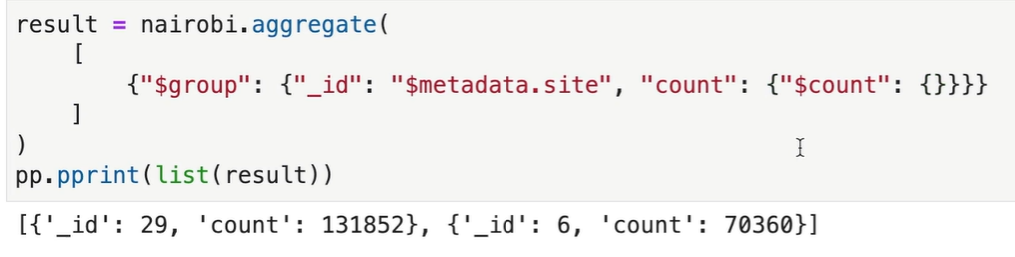

### Checking Distinct measurements in the collection
* Some of the collections have temperature readings. Do all of them have temperature readings?
* INPUT:
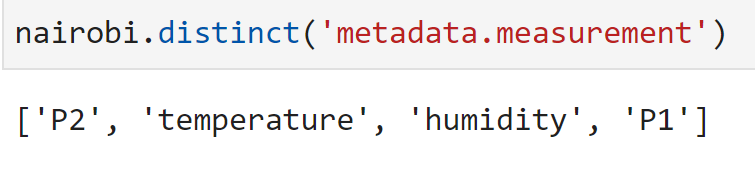
* There are infact 4 different types of measurements: temperature, humidity, P2 (PM2.5) and P1 (PM10).
* PM2.5 readings are our concern here

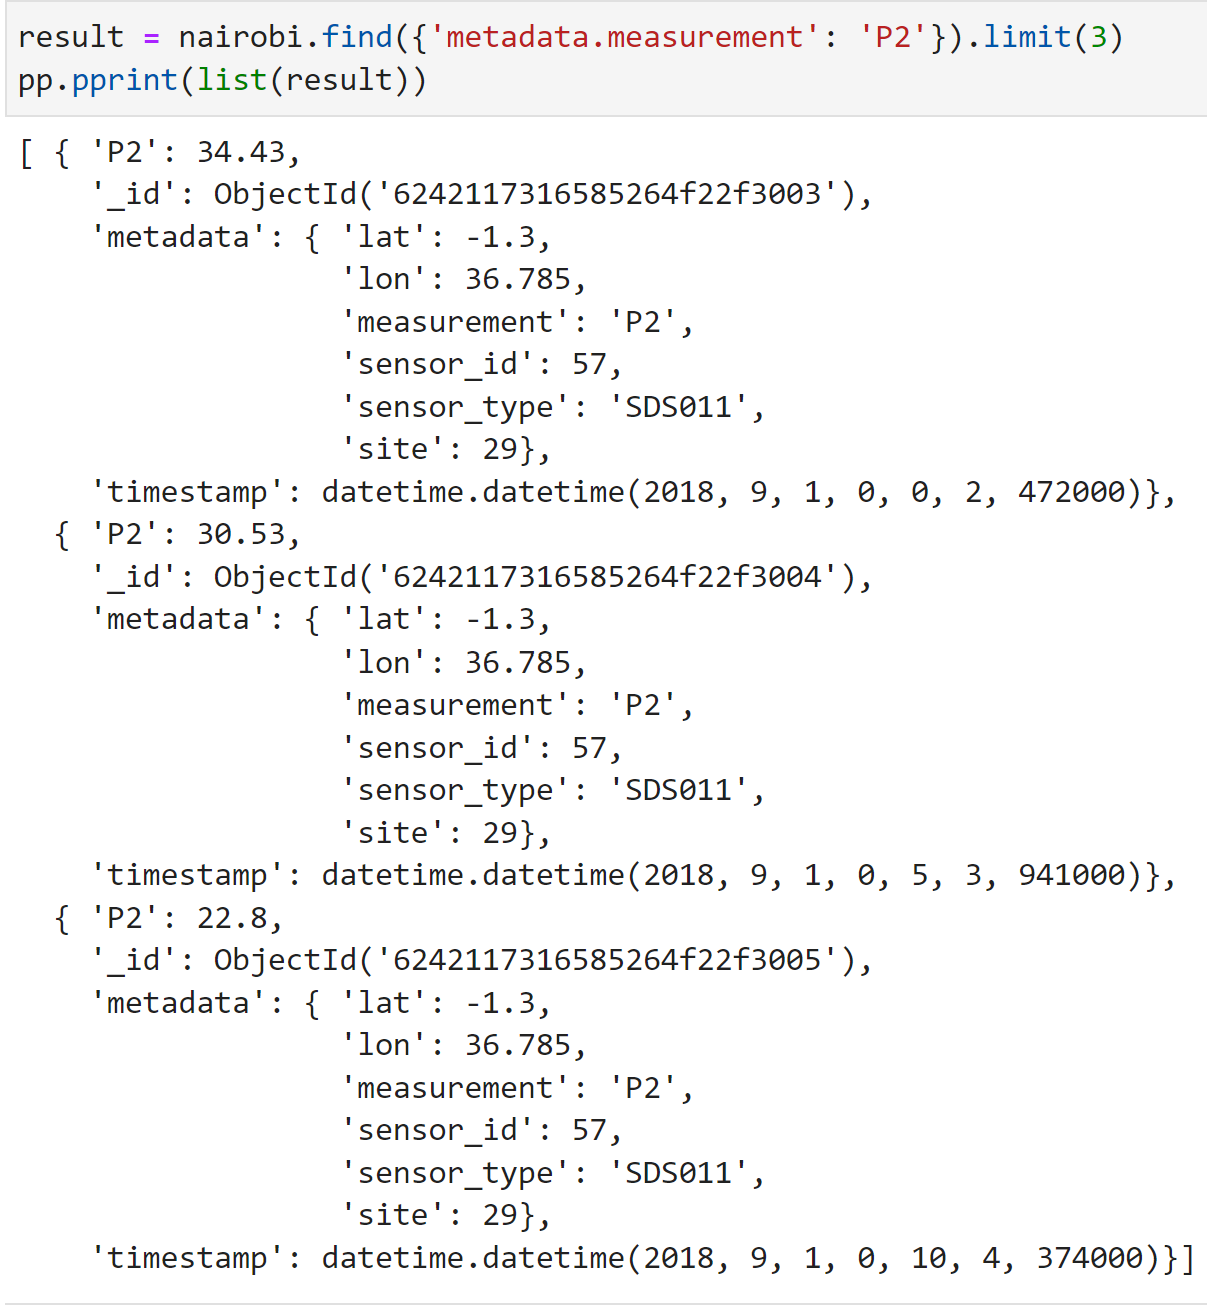### Finding PM2.5 Readings (P2)
* We need to find records where metadata measurements which are P2. We can limit it to 3. Just like head() is used to not see the entire pandas dataframe
* 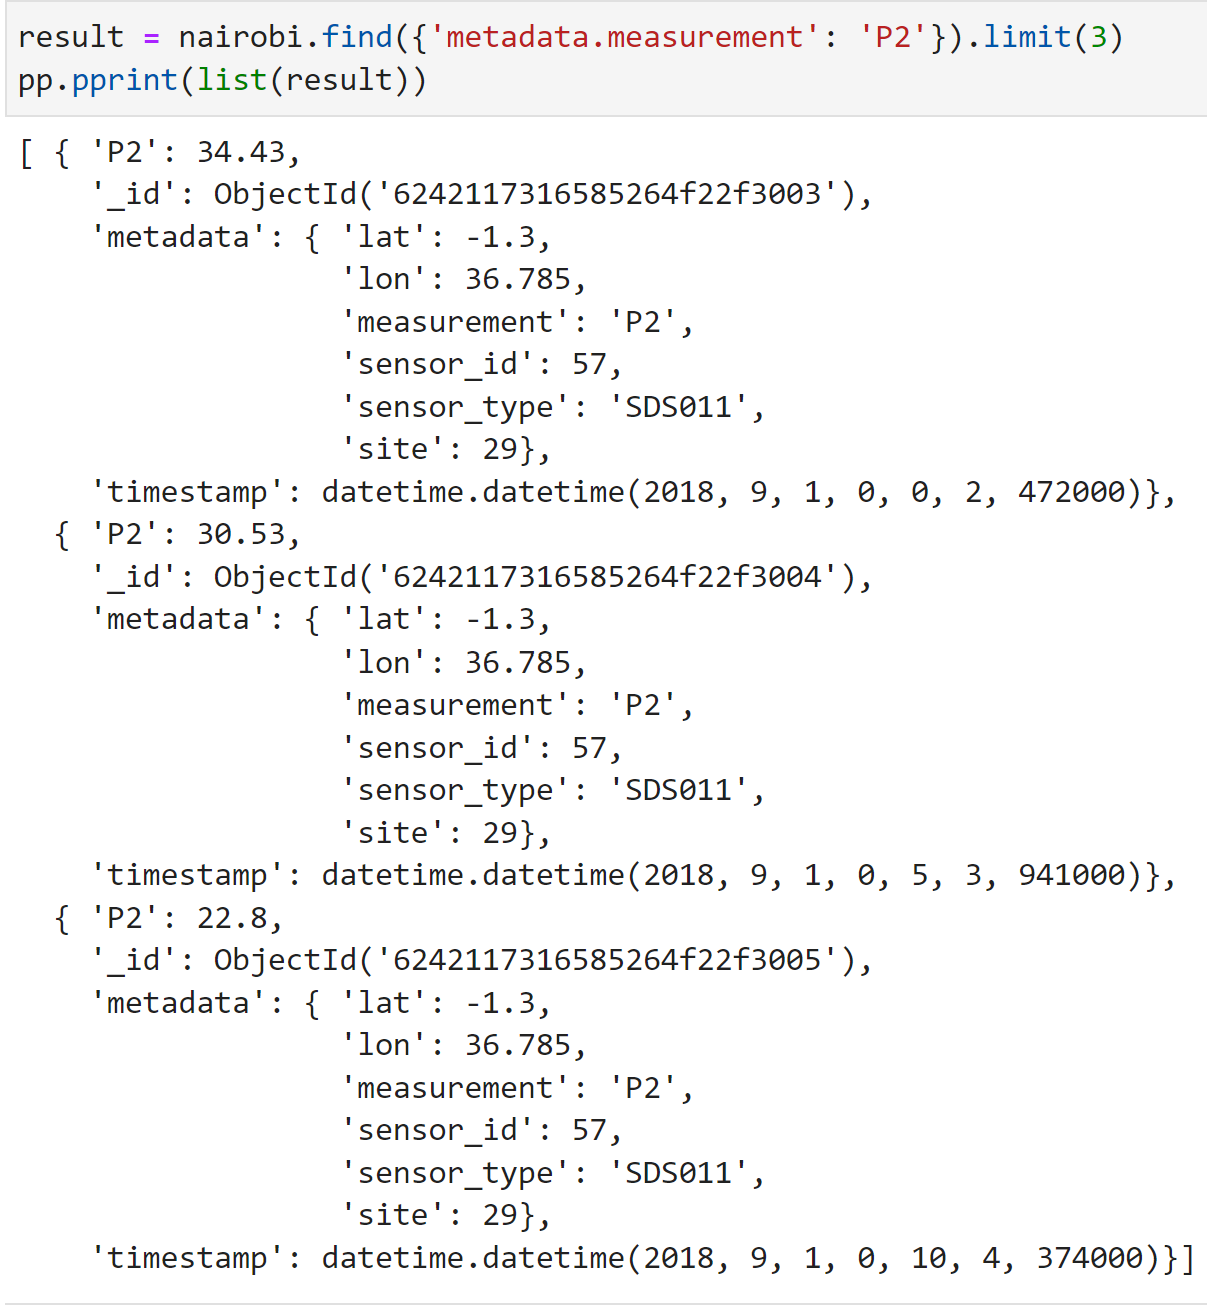
* **These records are similar to what was seen before. They have unique primary key, a lot of metadata, timestamp**
* **Most importantly, they have a P2 key value pair instead of temperature.**
* **Here we can see the flexibility in the semi-structured data. Not every record needs to have a temperature reading or P1 reading. It can be anything**

### Aggregating by Measurements
* we have multiple sites (6,29) and multiple types of readings (p2, p1, temperature..), but we need to find how many readings each site has
* **To get the number of readings across both sites,** 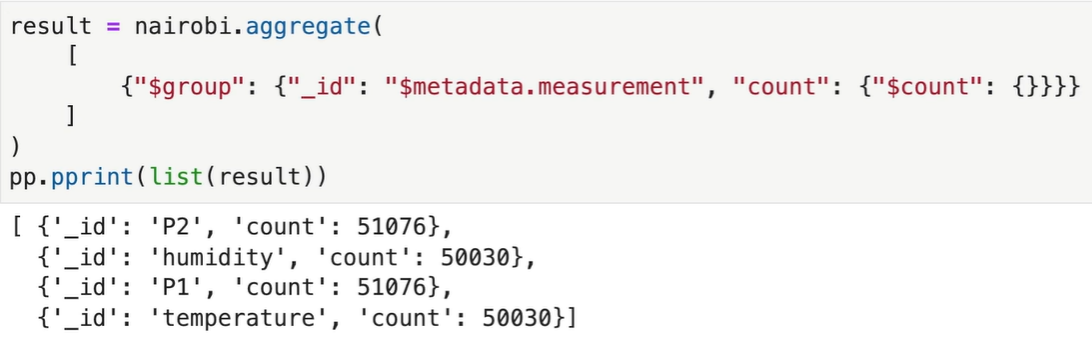

* **To limit this aggregation to just one site (e.g. site 6), one step needs to be added to the pipeline before group step**
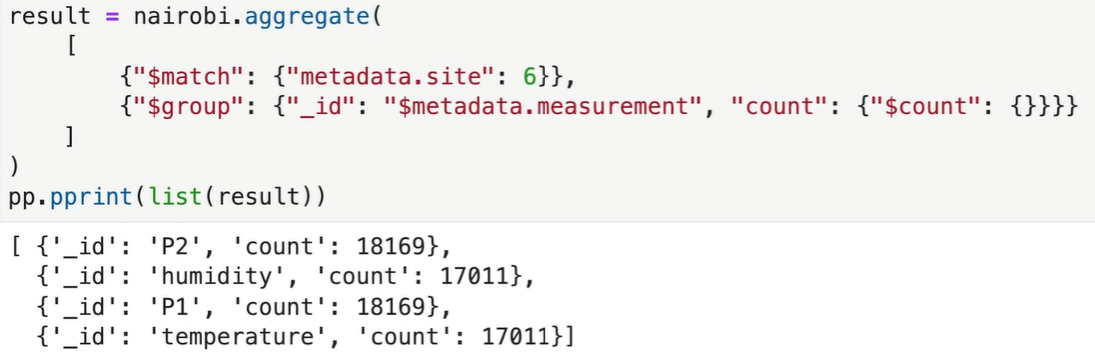

### Aggregating the readings across site 29
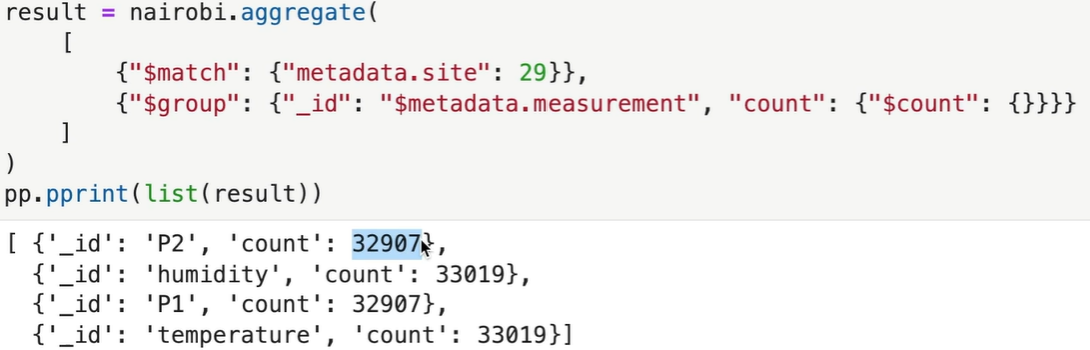
**It turns out that site 29 has almost double the readings as site 6. So it makes sense to use data from site 29 to build the linear regression model to predict PM2.5**

# 3. Importing Data from MongoDB
* We have decided we want to focus only on site 29 and on P2 measurement readings there.
* We need to create a find query which gives the data we want and deliver us in the format we need
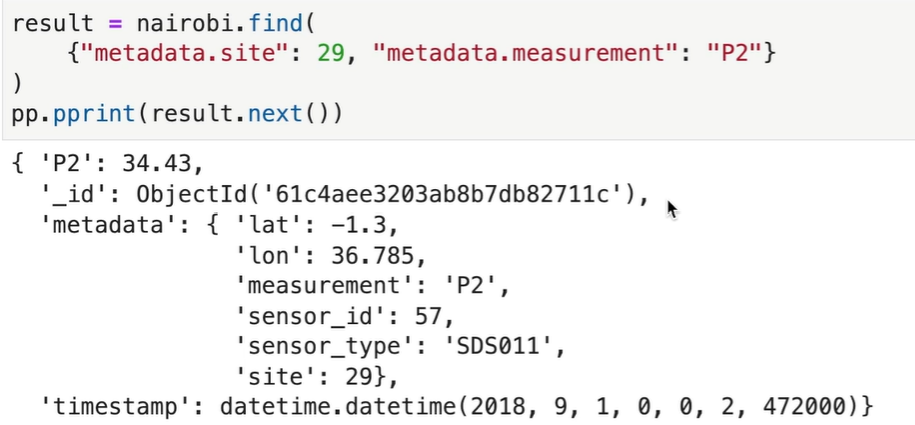
* `result.next()` takes the iterator and gives first result. Similar to limit(1)
* We need to modify this find query because we do not require metadata information, or the `_id`. 
* For that we need to change projection of this data by adding a projection argument to the method
* For the keys which we want to see we use 1, and 0 for those we don't need
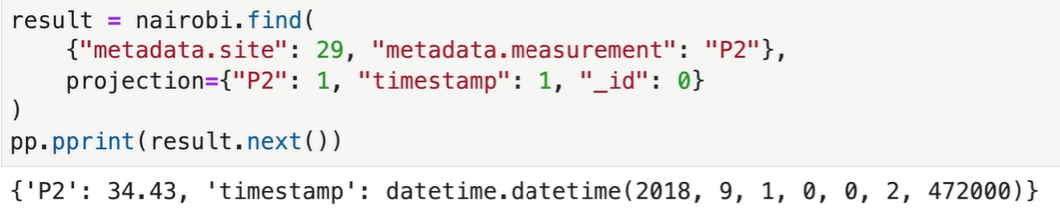

### Reading query into the dataframe
* We put the result variable into a pandas dataframe
* We also need to set the timestamp as index for time-series data analysis
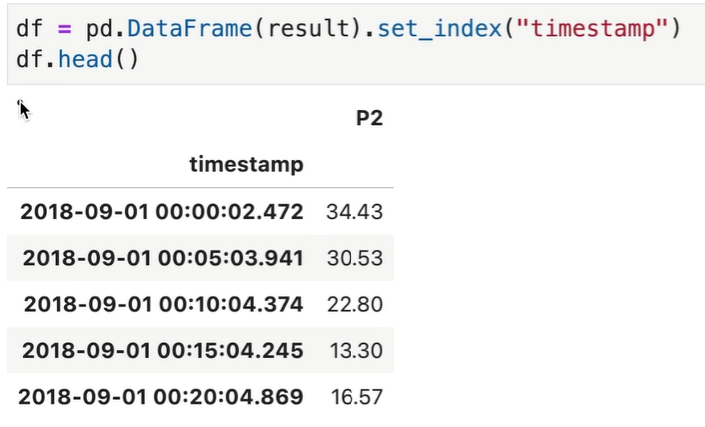
* We will get a key error after setting timestamp as index, saying timestamp is not in column.
* This is because of the nature of iterator. Iterator does not store data into a memory. As soon as it is done dishing information, it is exhausted. The way to overcome this is by re-running the find query

In [ ]:
# Actual code
client = MongoClient(host='localhost', port='27017')
pp.pprint(list(client.list_databases()))
db = client['air-quality']

for c in db.list_collections():
    print(c['name'])

nairobi = db['nairobi']
nairobi.count_documents({}) # Checking number of documents in the nairobi collection

result = nairobi.find_one({}) # Checking a record
pp.pprint(result)

nairobi.distinct('metadata.site') # finding out the number of unique sites

#Counting the number of documents in each site
print("Documents from site 6:", nairobi.count_documents({'metadata.site':6}))
print("Documents from site 29:", nairobi.count_documents({'metadata.site':29}))

# Performing aggregating calculations using Pymongo to find documents in each site
# This is useful when there are hundreds of sites/items
result = nairobi.aggregate(
    [
        {'$group': {'_id': '$metadata.site', 'count': {'$count': {}}}}
    ]
)
pp.pprint(list(result))

# Checking distinct measurements in a collection
nairobi.distinct('metadata.measurement')

# Querying a collection using Pymongo to find P2 records
result = nairobi.find({'metadata.measurement': 'P2'}).limit(3)
pp.pprint(list(result))

# Performing aggregation calculations on documents using Pymongo
result = nairobi.aggregate(
    [
        {'$match': {'metadata.site': 29}},
        {'$group': {'_id': '$metadata.measurement', 'count': {'$count': {}}}}
    ]
)
pp.pprint(list(result))

# querying a collection
result = nairobi.find(
    {'metadata.site': 29, 'metadata.measurement': 'P2'},
    projection = {'P2': 1, 'timestamp': 1, '_id': 0}
)
pp.pprint(result.next())

# Creating a DataFrame from dictionary using pandas
df = pd.DataFrame(result).set_index('timestamp')
df.head()